In [90]:
import cv2
import numpy as np
import os
from skimage.feature import local_binary_pattern
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from IPython.display import Image, display
import random

# Definción de funciones

Encapsular el código en funciones nos facilitará llevar a cabo la corrección y modificación del mismo en el futuro

### Extracción de features de color 

In [91]:
# Función para extraer features del histograma de color de una imagen
def extract_color_features(image, bins_per_channel=256): 
    # Lista para almacenar las features del histograma
    hist_features = []
    # Itera sobre cada canal de color de la imagen
    for i in range(3):  
        # Calcula el histograma del canal de color
        hist = cv2.calcHist([image], [i], None, [bins_per_channel], [0, 256])
        # Normaliza el histograma
        hist = cv2.normalize(hist, hist).flatten()
        # Agrega el histograma a la lista de features
        hist_features.extend(hist)
    # Retorna las features del histograma
    return hist_features

### Extracción de features de bordes

In [92]:
# Función para extraer features del histograma de bordes de una imagen
def extract_edge_features(image, low_threshold=100, high_threshold=200):
    # Convierte la imagen a escala de grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Aplica el detector de bordes de Canny
    edges = cv2.Canny(gray, low_threshold, high_threshold)
    # Calcula el porcentaje de píxeles de borde
    edge_feature = [np.sum(edges) / (edges.size * 255)] 
    # Retorna las features de borde
    return edge_feature

### Extracción de features LBP

In [93]:
# Parámetros para LBP
P = 8  # Número de puntos
R = 1  # Radio

# Función para extraer features LBP de una imagen
def extract_lbp_features(image, num_points=P, radius=R, eps=1e-7):
    # Calcula el LBP de la imagen
    lbp = local_binary_pattern(image, num_points, radius, method="uniform")
    # Calcula el histograma LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, num_points + 3), range=(0, num_points + 2))
    # Convierte el histograma a tipo flotante para realizar operaciones de punto flotante
    hist = hist.astype("float")
    # Normaliza el histograma dividiéndolo por la suma de todos los valores en el histograma más un pequeño valor epsilon para evitar división por cero
    hist /= (hist.sum() + eps)
    # Devuelve el histograma normalizado como las features LBP de la imagen
    return hist

### Combinación de features extraídas

In [94]:
# Función para extraer features combinadas de una imagen
def extract_combined_features(image, bins_per_channel=256, low_threshold=100, high_threshold=200):
    # Extrae features de color
    color_features = extract_color_features(image, bins_per_channel=bins_per_channel)
    # Extrae features de borde
    edge_features = extract_edge_features(image, low_threshold=low_threshold, high_threshold=high_threshold)
    # Convierte la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Extrae features LBP
    lbp_features = extract_lbp_features(gray_image)
    # Combina las features en un solo vector
    combined_features = np.hstack([color_features, edge_features, lbp_features])
    # Retorna el vector defeatures combinadas
    return combined_features

### Lectura, redimensionamiento y extracción de las features de las imágenes

In [95]:
# Función para procesar un directorio de imágenes
def process_images(directory, target_size=(128, 128)):
    # Lista para almacenar las features combinadas de todas las imágenes
    combined_features_list = []
    # Itera sobre cada archivo en el directorio
    for filename in os.listdir(directory):
        # Verifica si el archivo es una imagen
        if filename.endswith('.jpg'):
            # Lee la imagen
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            # Redimensiona la imagen al tamaño objetivo
            img = cv2.resize(img, target_size)
            # Extrae features combinadas de la imagen
            combined_features = extract_combined_features(img)
            # Agrega las features combinadas a la lista
            combined_features_list.append(combined_features)
    # Retorna la lista de features combinadas
    return combined_features_list

# Preprocesamiento y extracción de features

Gracias al encapsulamiento del código en funciones podemos realizar el proceso en dos líneas de código.

In [96]:
# Directorio de imágenes
directory_path = 'technical_test_images' # Cambiar por el directorio que contiene las imágenes
# Procesa las imágenes en el directorio
features = process_images(directory_path)

### Normalización

In [97]:
# Convierte la lista de features a un array de Numpy
features_array = np.array(features) 
# Normaliza las features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_array)

# Reducción de la dimensionalidad

In [98]:
# Reducción de dimensionalidad con PCA
pca = PCA(n_components=500)
features_reduced = pca.fit_transform(features_normalized)

# Implementación y ajuste del algoritmo

### Ajuste del parámetro eps

El algoritmos seleccionado es DBSCAN, para usar ese algoritmo eficientemente es importante seleccionar un eps adecuado, para ayudarnos a seleccionar un número apropiado hacemos uso de la siguiente gráfica

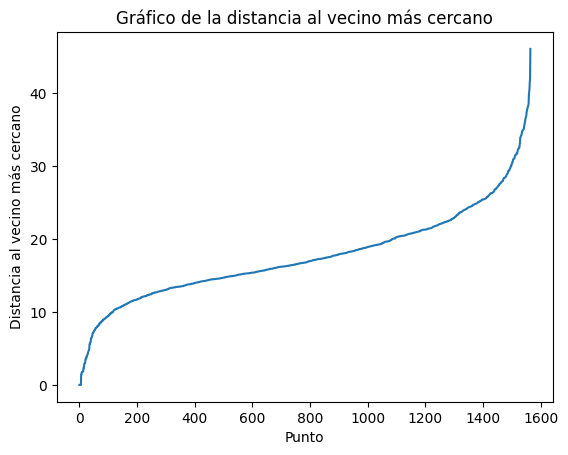

In [99]:
# Define el número mínimo de muestras para considerar un punto como un punto central en DBSCAN
min_samples = 5
# Crea una instancia de la clase NearestNeighbors con el número de vecinos igual al número mínimo de muestras
neigh = NearestNeighbors(n_neighbors=min_samples)
# Ajusta el modelo a las features reducidas para encontrar los vecinos más cercanos
nbrs = neigh.fit(features_reduced)
# Encuentra las distancias y los índices de los `min_samples` vecinos más cercanos para cada punto
distances, indices = nbrs.kneighbors(features_reduced)
# Ordena las distancias en orden ascendente para cada punto
distances = np.sort(distances, axis=0)
# Selecciona la distancia al primer vecino más cercano (ignorando la distancia a sí mismo que es 0)
# Esto se hace seleccionando la segunda columna ya que la primera columna son distancias a sí mismos (0)
distances = distances[:,1]

# Grafica las distancias al vecino más cercano para cada punto en orden ascendente
plt.plot(distances)
plt.xlabel('Punto')
plt.ylabel('Distancia al vecino más cercano')
plt.title('Gráfico de la distancia al vecino más cercano')
plt.show()

# Este código se utiliza para ayudar a seleccionar un valor apropiado para el parámetro eps en DBSCAN.
# El gráfico muestra la distancia al k-ésimo vecino más cercano para cada punto, ordenados en orden ascendente.
# La idea es encontrar el "codo" del gráfico, donde la tasa de aumento cambia bruscamente,
# indicando el umbral donde la densidad alrededor de los puntos disminuye.
# Este punto de "codo" a menudo se utiliza como una heurística para elegir eps.

### Implementación del algoritmo

In [100]:
# Distancia máxima entre dos muestras para ser consideradas en la misma vecindad
eps = 10
# Crea una instancia de la clase DBSCAN con el parámetro eps
dbscan = DBSCAN(eps=eps, min_samples=min_samples) 
# Ajusta el modelo a las features reducidas
cluster_labels = dbscan.fit_predict(features_reduced)

# Evaluación de los clústers

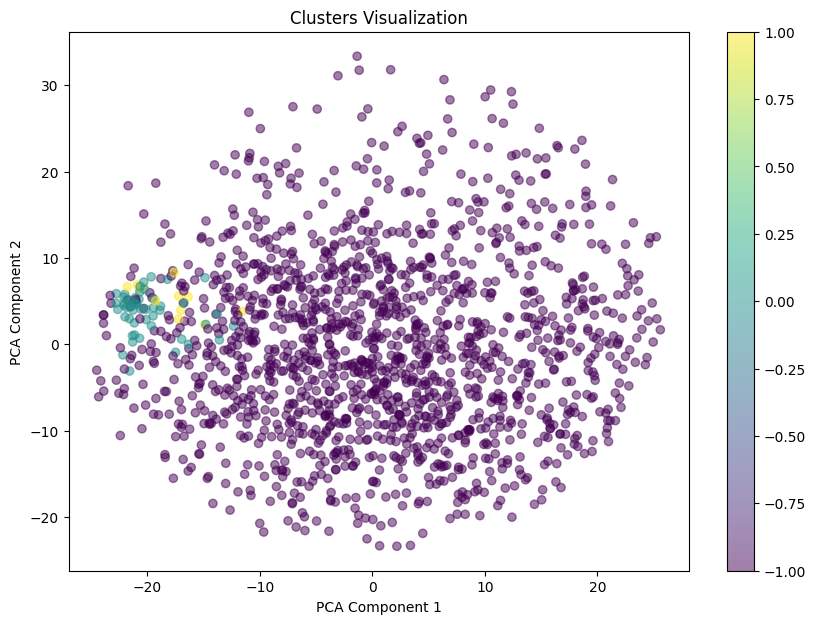

In [101]:
# Grafica los clusters
plt.figure(figsize=(10, 7))
plt.scatter(features_reduced[:, 0], features_reduced[:, 1], c=cluster_labels, cmap='viridis', marker='o', alpha=0.5)
plt.title('Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

In [102]:
# Función para asociar las etiquetas de los clusters con los nombres de las imágenes
def associate_cluster_labels(image_filenames, cluster_labels):
    # Diccionario para almacenar las asociaciones de los clusters
    cluster_associations = {}
    # Itera sobre cada nombre de archivo y etiqueta de cluster
    for filename, label in zip(image_filenames, cluster_labels):
        # Verifica si la etiqueta de cluster ya está en el diccionario
        if label not in cluster_associations:
            # Si no está, crea una lista vacía para esa etiqueta de cluster
            cluster_associations[label] = []
        # Agrega el nombre de archivo a la lista asociada con la etiqueta de cluster
        cluster_associations[label].append(filename)
    # Retorna el diccionario de asociaciones de clusters
    return cluster_associations

In [103]:
# Lista de nombres de archivo de imágenes
image_filenames = [filename for filename in os.listdir(directory_path) if filename.endswith('.jpg') or filename.endswith('.png')]
# Asocia las etiquetas de los clusters con los nombres de las imágenes
cluster_associations = associate_cluster_labels(image_filenames, cluster_labels)

In [104]:
# Función para imprimir imágenes aleatorias de cada cluster
def print_random_images_from_clusters(cluster_associations, directory, n=5):
    # Itera sobre cada etiqueta de cluster y la lista de nombres de archivo asociada
    for cluster_label, filenames in cluster_associations.items():
        print(f"Cluster {cluster_label}:")
        # Muestra n imágenes aleatorias de cada cluster
        selected_filenames = random.sample(filenames, min(len(filenames), n)) 
        for filename in selected_filenames:
            filepath = os.path.join(directory, filename)
            display(Image(filename=filepath))
            print(filename)
        # Separador entre clusters
        print("\n" + "-" * 80 + "\n") 

Cluster -1:


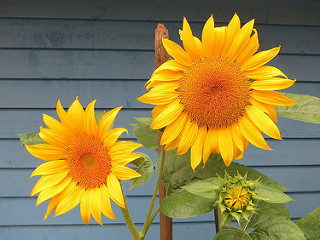

imagen751.jpg


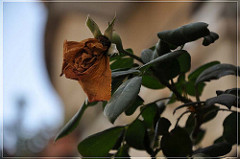

imagen507.jpg


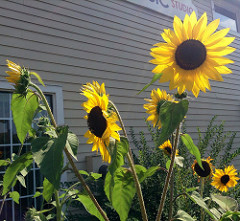

imagen588.jpg


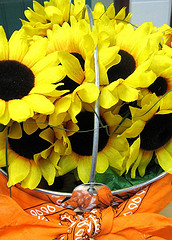

imagen566.jpg


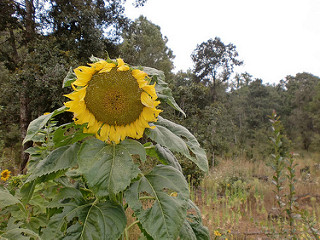

imagen825.jpg

--------------------------------------------------------------------------------

Cluster 0:


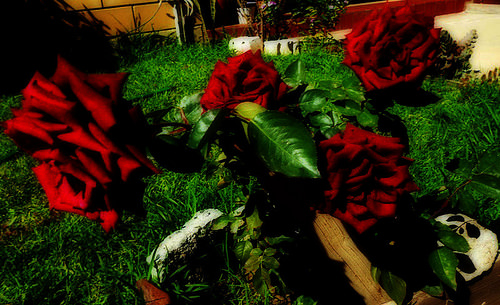

imagen1440.jpg


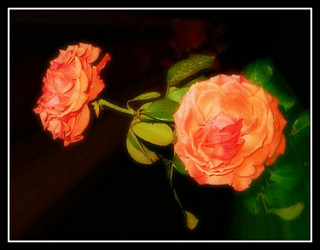

imagen264.jpg


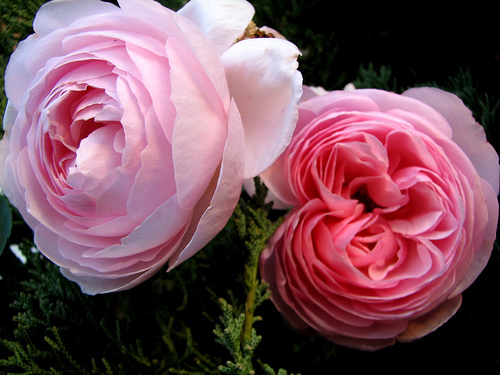

imagen1308.jpg


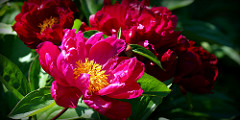

imagen112.jpg


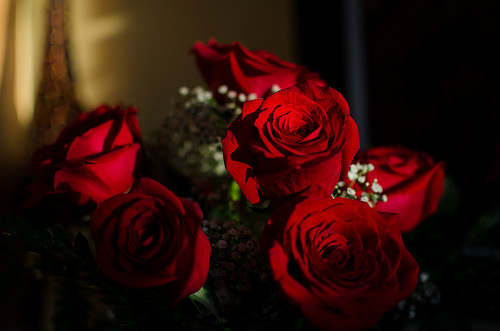

imagen1052.jpg

--------------------------------------------------------------------------------

Cluster 1:


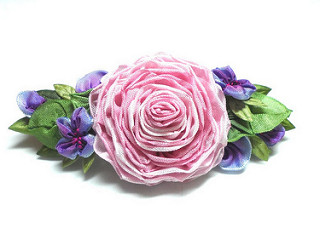

imagen231.jpg


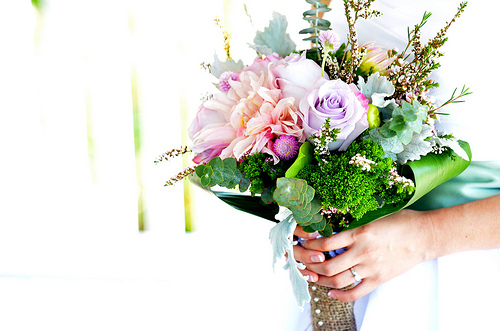

imagen1263.jpg


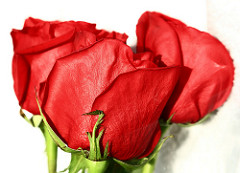

imagen185.jpg


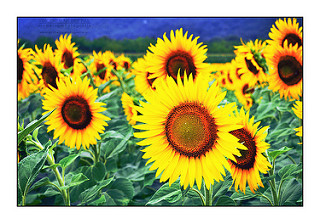

imagen1160.jpg


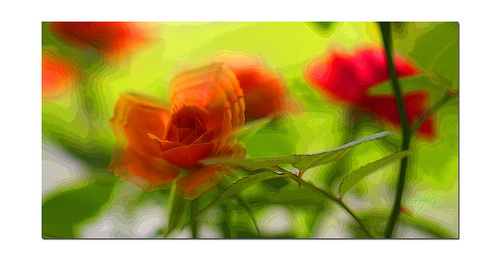

imagen1192.jpg

--------------------------------------------------------------------------------



In [105]:
print_random_images_from_clusters(cluster_associations, "technical_test_images")